#### Import libraries and imports

In [168]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics
from sklearn import tree, svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import VotingClassifier
print('Finished loading libraries and imports')

Finished loading libraries and imports


#### Loading and merging the data

In [139]:
le = preprocessing.LabelEncoder()
df_matches = pd.read_csv(
    'data/matchResults.csv').merge(pd.read_csv('data/matchLineups.csv'), on='Match ID')
df_statistics = pd.read_csv('data/playerStats.csv')
df_teams = pd.read_csv('data/teams.csv')
print('Finished loading and merging the data')

Finished loading and merging the data


#### Loading functions

In [199]:
def clean_matches_dataset():
    df = pd.DataFrame()
    df['match_id'] = df_matches['Match ID']
    df['map'] = df_matches['Map']
    df['team_1_id'] = df_matches['Team 1 ID']
    df['team_2_id'] = df_matches['Team 2 ID']
    df['team_1_score'] = df_matches['Team 1 Half 1 Score'] + \
        df_matches['Team 1 Half 2 Score'] + df_matches['Team 1 Overtime Score']
    df['team_2_score'] = df_matches['Team 2 Half 1 Score'] + \
        df_matches['Team 2 Half 2 Score'] + df_matches['Team 2 Overtime Score']
    print('Finished cleaning matches dataset')
    return df


def decide_winners(dataframe):
    for i, row in dataframe.iterrows():
        dataframe.set_value(
            i, 'winning_team_nr', 1 if row['team_1_score'] > row['team_2_score'] else 2)
        dataframe.set_value(
            i, 'winning_team_id', row['team_1_id'] if row['team_1_score'] > row['team_2_score'] else row['team_2_id'])
    print('Finished deciding winners')
    return dataframe


def calculate_winrate_for_team_on_map(df_total, team_id, map_id):
    matches = pd.DataFrame()
    won_matches = pd.DataFrame()

    df_filtered = df_total.loc[(df_total['team_1_id'] == team_id) & (
        df_total['map'] == map_id)]
    df_filtered = df_filtered.append(
        df_total.loc[(df_total['team_2_id'] == team_id) & (df_total['map'] == map_id)])
    matches = matches.append(df_filtered)
    won_matches = won_matches.append(df_total.loc[(
        df_total['winning_team_id'] == team_id) & (df_total['map'] == map_id)])

    return len(won_matches) / len(matches) * 100


def calculate_winrate_for_matches(df_total):
    already_calculated_keys = {}
    for i, row in df_total.iterrows():
        team_1_key = str(row['map']) + str(row['team_1_id'])
        team_2_key = str(row['map']) + str(row['team_2_id'])
        if team_1_key not in already_calculated_keys:
            winrate = calculate_winrate_for_team_on_map(
                df_total, row['team_1_id'], row['map'])
            already_calculated_keys[team_1_key] = winrate
            df_total.set_value(i, 'team_1_winrate', winrate)
        else:
            df_total.set_value(i, 'team_1_winrate',
                               already_calculated_keys[team_1_key])
        if team_2_key not in already_calculated_keys:
            winrate = calculate_winrate_for_team_on_map(
                df_total, row['team_2_id'], row['map'])
            already_calculated_keys[team_2_key] = winrate
            df_total.set_value(i, 'team_2_winrate', winrate)
        else:
            df_total.set_value(i, 'team_2_winrate',
                               already_calculated_keys[team_2_key])
    print('Finished calculating winrates')
    df_total.to_csv('winrates.csv', index=False)
    return df_total


def plot_team_winrates(team_id, team_name):
    maps = ['Nuke', 'Dust2', 'Inferno', 'Cobblestone', 'Overpass', 'Mirage', 'Cache', 'Train', 'Season']
    map_nrs = le.fit_transform(maps)
    winrate_per_map = {}
    
    for _map in maps:
        winrate_per_map[_map] = calculate_winrate_for_team_on_map(df_final_data, team_id, _map)
    
    fig, ax = plt.subplots(1,1) 

    plt.title(team_name + ' win rate per map')
    plt.xlabel('Map')
    plt.ylabel('Win rate')
    plt.ylim(0, 100)
    plt.xlim(-1, len(maps))
    ax.scatter(winrate_per_map.keys(), winrate_per_map.values(), alpha=1)
    ax.set_xticks(map_nrs)
    ax.set_xticklabels(winrate_per_map.keys(), rotation='vertical', fontsize=18)
    plt.show()


def cross_validate(clf, x, y, method_name):
    cross_val = KFold(5, shuffle=True, random_state=0)
    accuracy_scores = []
    recall_scores = []
    precision_scores = []
    
    for train_index, test_index in cross_val.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(x_train, y_train)
        pred = clf.predict(x_test)
        accuracy_scores += [accuracy_score(y_test, pred.round())]
        recall_scores += [recall_score(y_test, pred.round())]
        precision_scores += [precision_score(y_test, pred.round())]

    score_string = """
    ------------------------------------------
    {6}:
    Accuracy: {0}
    Accuracy mean: {1:.3f}

    Recall: {2}
    Recall mean: {3:.3f}

    Precision: {4}
    Precision mean: {5:.3f}
    ------------------------------------------
    """.format(str(accuracy_scores), 
               np.mean(accuracy_scores), 
               str(recall_scores),
               np.mean(recall_scores),
               str(precision_scores),
               np.mean(precision_scores),
               method_name)
    
    print(score_string)


def decision_trees(df):
    clf = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=3, min_samples_leaf=5)
    cross_validate(clf,  df[['team_1_winrate', 'team_2_winrate']].values, df['winning_team_nr'].values, 'Decision trees')


def support_vector_machines(df):
    clf = svm.SVC()
    cross_validate(clf,  df[['team_1_winrate', 'team_2_winrate']].values, df['winning_team_nr'].values, 'Support Vector Machines')
   

def neural_network_mlp(df):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    cross_validate(clf,  df[['team_1_winrate', 'team_2_winrate']].values, df['winning_team_nr'].values, 'Neural Network MLP')


def random_forest(df):
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    cross_validate(clf,  df[['team_1_winrate', 'team_2_winrate']].values, df['winning_team_nr'].values, 'Random Forest')
    
    
def linear_regression(df):
    clf = LinearRegression()
    cross_validate(clf,  df[['team_1_winrate', 'team_2_winrate']].values, df['winning_team_nr'].values, 'Linear Regression')


def naive_bayes(df):
    clf = GaussianNB()
    cross_validate(clf,  df[['team_1_winrate', 'team_2_winrate']].values, df['winning_team_nr'].values, 'Naive Bayes')
    
def ensemble_learn_hard(df, clf1, clf2, clf3, clf4):
    eclf = VotingClassifier(estimators=[('rf', clf1), ('gnb', clf2), ('dtc', clf3), ('mlp', clf4)], voting='hard')
    cross_validate(eclf, df[['team_1_winrate', 'team_2_winrate']].values, df['winning_team_nr'].values, 'Ensemble Learning Hard Voting')
    
def ensemble_learn_soft(df, clf1, clf2, clf3, clf4):
    eclf = VotingClassifier(estimators=[('rf', clf1), ('gnb', clf2), ('dtc', clf3), ('mlp', clf4)], voting='soft')
    cross_validate(eclf, df[['team_1_winrate', 'team_2_winrate']].values, df['winning_team_nr'].values, 'Ensemble Learning Soft Voting')
    

print('Finished loading functions')

Finished loading functions


#### Split dataset into test and train sets

In [161]:
df_cleaned_data = decide_winners(clean_matches_dataset())
df_final_data = calculate_winrate_for_matches(df_cleaned_data)

Finished cleaning matches dataset
Finished deciding winners
Finished calculating winrates


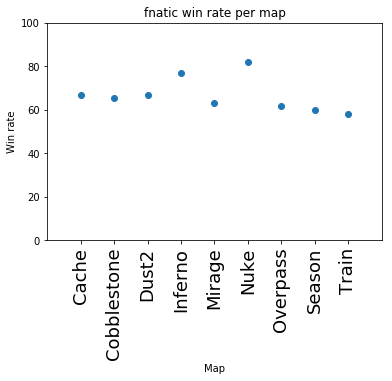

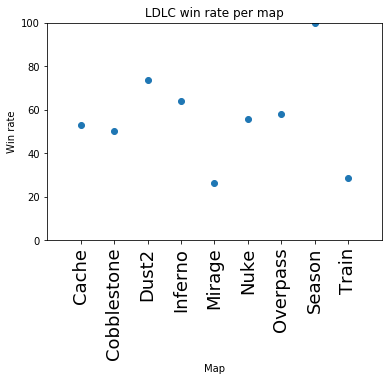

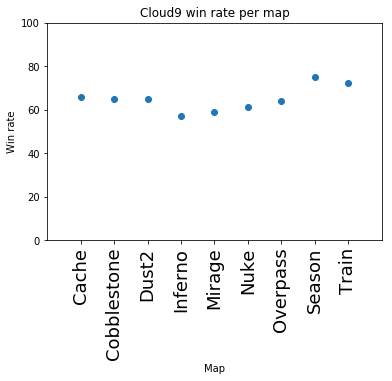

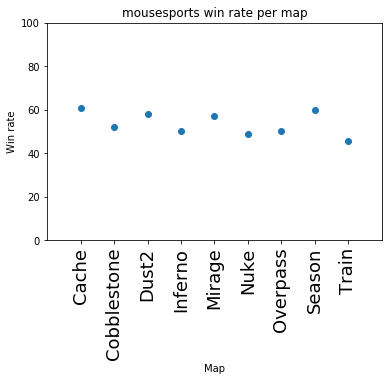

In [167]:
plot_team_winrates(4991, 'fnatic')
plot_team_winrates(4674, 'LDLC')
plot_team_winrates(5752, 'Cloud9')
plot_team_winrates(4494, 'mousesports')

#### Examine and predict by using machine learning classifiers

In [45]:
decision_trees(pd.read_csv('winrates.csv'))
support_vector_machines(pd.read_csv('winrates.csv'))
neural_network_mlp(pd.read_csv('winrates.csv'))
random_forest(pd.read_csv('winrates.csv'))
linear_regression(pd.read_csv('winrates.csv'))
naive_bayes(pd.read_csv('winrates.csv'))
print('Finished getting accuracy of all alghoritms')


    ------------------------------------------
    Decision trees:
    Accuracy: [0.70792940591598308, 0.70954511558538402, 0.71995027967681791, 0.71124922311995031, 0.71995027967681791]
    Accuracy mean: 0.714

    Recall: [0.68853560232870581, 0.72672739391246388, 0.69457262140188969, 0.68183866606579535, 0.69478182636077368]
    Recall mean: 0.697

    Precision: [0.76227069905800693, 0.74714481498401097, 0.78553677932405563, 0.76860553721107439, 0.77515683814303638]
    Precision mean: 0.768
    ------------------------------------------
    

    ------------------------------------------
    Support Vector Machines:
    Accuracy: [0.72445935868754663, 0.73117076808351977, 0.72964574269732752, 0.72504661280298321, 0.73710379117464264]
    Accuracy mean: 0.729

    Recall: [0.79064039408866993, 0.81248611419684513, 0.80048341023950775, 0.80013519603424965, 0.81151596941070625]
    Recall mean: 0.803

    Precision: [0.73363806357781014, 0.734927652733119, 0.74195519348268835, 0.7

#### Ensemble Learning

In [200]:
ensemble_learn_hard(df_final_data,
               RandomForestClassifier(max_depth=2, random_state=0), 
               GaussianNB(), 
               DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=3, min_samples_leaf=5), 
               MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1))


    ------------------------------------------
    Ensemble Learning Hard Voting:
    Accuracy: [0.72992791449167294, 0.7305493412875963, 0.73697949036668742, 0.72927284027346173, 0.74145431945307649]
    Accuracy mean: 0.734

    Recall: [0.81437527989252123, 0.82159520106642969, 0.80729509997802684, 0.8102748986029743, 0.81848852901484481]
    Recall mean: 0.814

    Precision: [0.73017466372214412, 0.73039699782737511, 0.7478119275391818, 0.72911597729115973, 0.74083876221498368]
    Precision mean: 0.736
    ------------------------------------------
    


In [201]:
ensemble_learn_soft(df_final_data,
               RandomForestClassifier(max_depth=2, random_state=0), 
               GaussianNB(), 
               DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=3, min_samples_leaf=5), 
               MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1))


    ------------------------------------------
    Ensemble Learning Soft Voting:
    Accuracy: [0.73253790703455135, 0.72769077802634852, 0.73561218147917962, 0.7300186451211933, 0.74095711622125549]
    Accuracy mean: 0.733

    Recall: [0.7931034482758621, 0.8175960897578316, 0.78971654581410677, 0.79067147363677337, 0.80049482681061623]
    Recall mean: 0.798

    Precision: [0.74255765199161428, 0.72871287128712869, 0.75440806045340048, 0.73842592592592593, 0.74831791421362492]
    Precision mean: 0.742
    ------------------------------------------
    
